In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Before you start - Make sure have access to the GPU

Let's make sure that we have access to GPU. We can use nvidia-smi command to do that. In case of any problems click ⋮ in top right corner, Accelerator and select GPU P100.

In [2]:
!nvidia-smi

Fri Jun 23 04:33:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

NOTE: To make it easier for us to manage datasets, images and models we create a HOME constant.

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /kaggle/working


## Install Segment Anything Model (SAM)

In [4]:
%cd {HOME}

!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/kaggle/working
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-btp8p2i9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-btp8p2i9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... - \ done


In [5]:
!pip install -q supervision

**Download SAM weights: ViT-h**

In [6]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/kaggle/working
/kaggle/working/weights


In [7]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/kaggle/working/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
IMAGE_PATH = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'

#### Generate masks with SAM

In [12]:
import cv2
import supervision as sv

image = cv2.imread(IMAGE_PATH)

sam_result = mask_generator.generate(image)

#### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [13]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

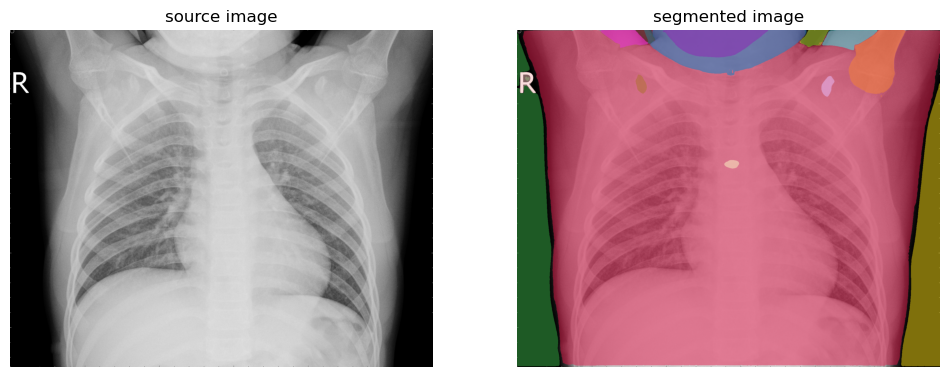

In [14]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## Generate Segmentation with Bounding Box

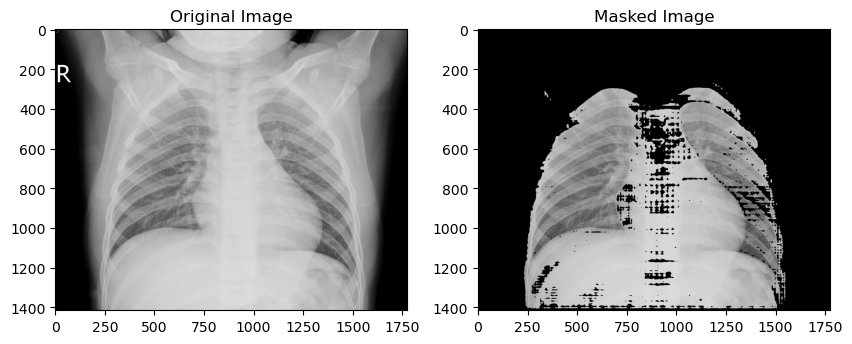

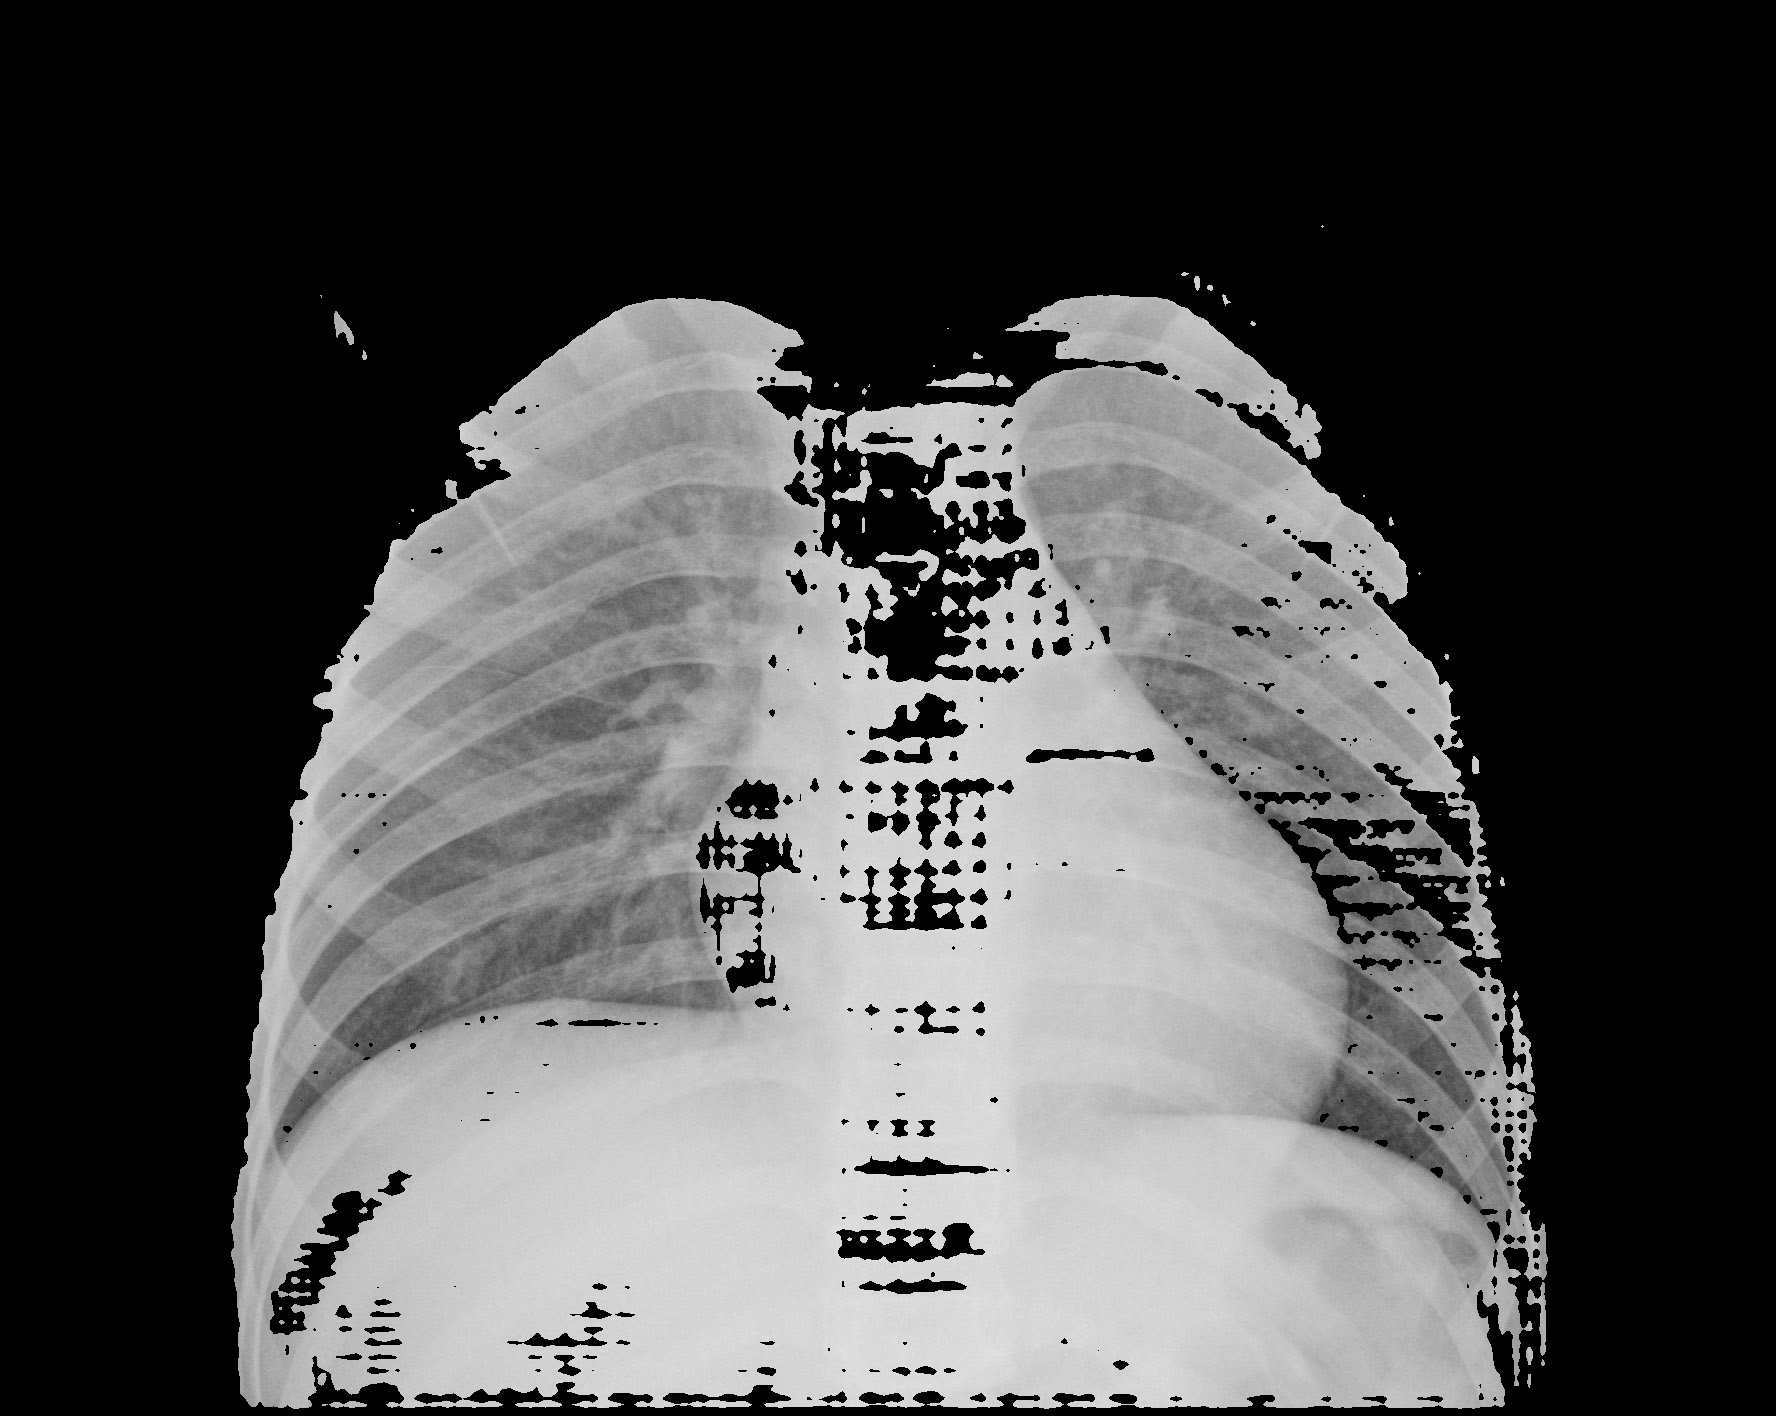

In [15]:
# Load the SAM model with ViT-H encoder
predictor = SamPredictor(sam)

# Set the image for the predictor
predictor.set_image(image)

# Generate a bounding box around the lung area
bbox = np.array([240, 200, 1600, 1400])

# Predict the mask using the bounding box as input prompt
masks, _, _ = predictor.predict(box=bbox)

# Get the first mask (assuming there is only one lung in the image)
mask = masks[0]

# Convert the mask to a numpy array and multiply by 255
mask = mask.astype(np.uint8) * 255

# Apply the mask to the image
masked_image = cv2.bitwise_and(image, image, mask=mask)


#### Show the original and masked images
# Import libraries
import matplotlib.pyplot as plt
from IPython.display import Image

# Show the original and masked images using matplotlib
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(masked_image)
plt.title("Masked Image")
plt.show()

# Save the masked image as a file
cv2.imwrite("masked_image.jpg", masked_image)

# Show the masked image using IPython
Image("masked_image.jpg")